In [1]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf

In [2]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes) # inspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [5]:
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

In [34]:
# Center data
# mean = np.mean(X_train, axis=0)
# X_train -= mean
# X_test -= mean
# print(mean)
mean = tf.reduce_mean(X_train, 0)
X_train -= mean
X_test -= mean
print(mean)

tf.Tensor([ 93.057976  98.03658  108.41788  ... 121.28262  114.02931  106.75122 ], shape=(1850,), dtype=float32)


In [45]:
#Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

(966, 1850)


In [40]:
#project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

(966, 1850) (1850, 300)
(966, 300)
(322, 300)


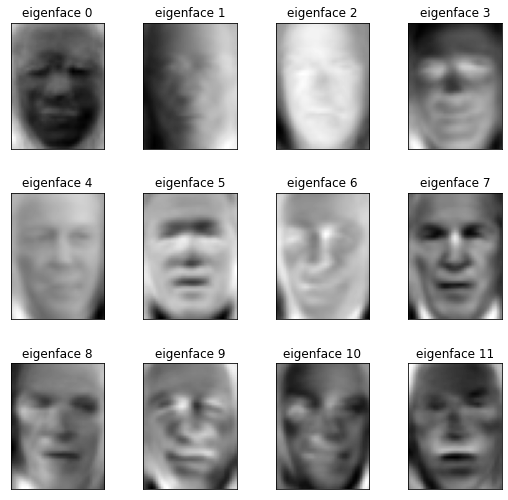

In [17]:
import matplotlib.pyplot as plt
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()


(966,)


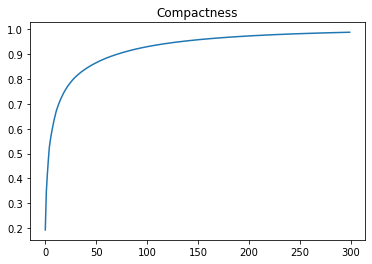

In [18]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [35]:
# Reimplement PCA using Tf
S, U, V = tf.linalg.svd(X_train, full_matrices=False)
components = tf.transpose(V)[:n_components]
#project into PCA subspace
X_transformed = tf.matmul(X_train, tf.transpose(components))
print(X_transformed.shape)
X_test_transformed = tf.matmul(X_test, tf.transpose(components))
print(X_test_transformed.shape)

(966, 150)
(322, 150)


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features=150,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
predictions = estimator.predict(X_test_transformed.numpy())
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
# print("Predictions", predictions)
# print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)

Total Testing 322
Total Correct: 209
Accuracy: 0.6490683229813664


In [38]:
print(classification_report(y_test, predictions, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.72      0.63      0.67        60
  Donald Rumsfeld       0.62      0.37      0.47        27
    George W Bush       0.64      0.92      0.76       146
Gerhard Schroeder       0.56      0.40      0.47        25
      Hugo Chavez       0.67      0.40      0.50        15
       Tony Blair       0.62      0.28      0.38        36

         accuracy                           0.65       322
        macro avg       0.55      0.43      0.46       322
     weighted avg       0.62      0.65      0.61       322



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Question 2

#### A)

In [4]:
from tensorflow.keras import models, layers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = X_train[:, :, np.newaxis, np.newaxis]
X_test = X_test[:, :, np.newaxis, np.newaxis]
print("X_train shape:", X_train.shape)

X_train shape: (966, 1850, 1, 1)


In [6]:
hidden_layers = 5000 
input_shape =  (966,1850,1,1)
model = tf.keras.models.Sequential()
model.add(layers.Flatten(input_shape=input_shape))
model.add(layers.Dense(768, activation='relu'))
model.add(layers.Dense(7))
model.summary()

ResourceExhaustedError: ignored

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=10, batch_size=250, validation_split=0.2)

ValueError: ignored